# Store Profile Classifier

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
transactions = pd.read_csv("/kaggle/input/dataset/Historical-transaction-data.csv")
storedata = pd.read_csv("/kaggle/input/dataset/Store-info.csv")
testdata = pd.read_csv("/kaggle/input/dataset/Testing-data.csv")

In [3]:
transactions.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


In [4]:
unique_shops = transactions['shop_id'].nunique()
print(unique_shops)

124


Basically there are 124 shops in total, we'll create a dataset from the transaction data

In [5]:
storedata

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low
...,...,...,...
119,SHOP087,527,NaN
120,SHOP050,411,NaN
121,SHOP061,699,NaN
122,SHOP056,597,NaN


# Planned Features
### Implemented
- Total Sales volume (total_vol)
- Total number of unique customers (total_customers)
- Largest volume by date? Largest volume in a single day (single_day_max_vol) ?
- Smallest volume by date? (single_day_max_vol)
- Sales volume per square foot (vol_per_sq_ft)
- Total Number of unique items (total_unique_items)
- Total transactions (n_transactions)
- Number of recurring customers (customer_id_repeating and customer_id_unique)
- Number of customers who visited only once (customer_id_single)

### Best Features so far

- shop_area_sq_ft, total_vol, total_customers = 0.6666
- single_day_min_vol, customer_id_single, shop_area_sq_ft = 0.5
- random forest = 0.416
- single_day_min_vol, customer_id_single = 0.375

### Target variable is shop_profile

## Adding total_vol and vol_per_sq_ft

In [6]:
# Compute the total volume of transactions for each store_id in the dataset dataframe
total_vol_by_store = transactions.groupby('shop_id').apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

total_vol_by_store = total_vol_by_store.rename('total_vol')

# Merge the total_vol_by_store series with the storedata dataframe on the 'store_id' column
storedata = pd.merge(storedata, total_vol_by_store, on='shop_id', how='left')
storedata["vol_per_sq_ft"] = storedata["total_vol"] / storedata["shop_area_sq_ft"]
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft
0,SHOP047,528,Moderate,842960,1596.515152
1,SHOP009,676,High,1970870,2915.488166
2,SHOP083,676,Low,1691985,2502.936391
3,SHOP117,676,Low,2325980,3440.798817
4,SHOP042,676,Low,1340215,1982.566568
...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651
120,SHOP050,411,NaN,2399125,5837.287105
121,SHOP061,699,NaN,2110800,3019.742489
122,SHOP056,597,NaN,3023805,5065.000000


## Adding total_customers

In [7]:
# group the transactions dataframe by shop_id and count the number of unique customer_ids
unique_customers = transactions.groupby('shop_id')['customer_id'].nunique()

# add a new column to the storedata dataframe with the counts of unique customers
storedata['total_customers'] = storedata['shop_id'].map(unique_customers)

In [8]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers
0,SHOP047,528,Moderate,842960,1596.515152,928
1,SHOP009,676,High,1970870,2915.488166,2498
2,SHOP083,676,Low,1691985,2502.936391,1900
3,SHOP117,676,Low,2325980,3440.798817,2037
4,SHOP042,676,Low,1340215,1982.566568,1841
...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083
120,SHOP050,411,NaN,2399125,5837.287105,1778
121,SHOP061,699,NaN,2110800,3019.742489,1746
122,SHOP056,597,NaN,3023805,5065.000000,2832


## Adding total_unique_items

In [9]:
# group the transactions dataframe by shop_id and count the number of unique item_descriptions
unique_items = transactions.groupby('shop_id')['item_description'].nunique()

# add a new column to the storedata dataframe with the counts of unique items
storedata['total_unique_items'] = storedata['shop_id'].map(unique_items)

## Adding single_day_max_vol

In [10]:
transactions['single_day_max_vol'] = transactions['item_price'] * transactions['quantity_sold']
total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_max_vol'].sum().reset_index()
highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_max_vol'].max().reset_index()

storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

## Adding single_day_min_vol

In [11]:
transactions['single_day_min_vol'] = transactions['item_price'] * transactions['quantity_sold']
total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_min_vol'].sum().reset_index()
highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_min_vol'].min().reset_index()

storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

In [12]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_max_vol,single_day_min_vol
0,SHOP047,528,Moderate,842960,1596.515152,928,35,71305,2020
1,SHOP009,676,High,1970870,2915.488166,2498,35,85750,9230
2,SHOP083,676,Low,1691985,2502.936391,1900,36,70610,8225
3,SHOP117,676,Low,2325980,3440.798817,2037,35,82170,6390
4,SHOP042,676,Low,1340215,1982.566568,1841,35,69185,5265
...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083,35,119750,2160
120,SHOP050,411,NaN,2399125,5837.287105,1778,31,157410,8015
121,SHOP061,699,NaN,2110800,3019.742489,1746,35,475215,6495
122,SHOP056,597,NaN,3023805,5065.000000,2832,35,162465,16780


## Adding n_transactions

In [13]:
# group transactions by shop_id and count the number of unique invoice_ids
transaction_counts = transactions.groupby('shop_id')['invoice_id'].nunique()

# add a new column to storedata with the transaction counts for each shop
storedata['n_transactions'] = storedata['shop_id'].map(transaction_counts)

In [14]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_max_vol,single_day_min_vol,n_transactions
0,SHOP047,528,Moderate,842960,1596.515152,928,35,71305,2020,1302
1,SHOP009,676,High,1970870,2915.488166,2498,35,85750,9230,3493
2,SHOP083,676,Low,1691985,2502.936391,1900,36,70610,8225,2718
3,SHOP117,676,Low,2325980,3440.798817,2037,35,82170,6390,3158
4,SHOP042,676,Low,1340215,1982.566568,1841,35,69185,5265,2495
...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083,35,119750,2160,1504
120,SHOP050,411,NaN,2399125,5837.287105,1778,31,157410,8015,3159
121,SHOP061,699,NaN,2110800,3019.742489,1746,35,475215,6495,2345
122,SHOP056,597,NaN,3023805,5065.000000,2832,35,162465,16780,4320


## Adding customer_id_repeating, customer_id_unique and customer_id_single

In [15]:
# Get a dataframe with the number of unique customers who visited each shop
unique_visits = transactions.groupby(['shop_id'])['customer_id'].nunique()

# Get a dataframe with the number of customers who visited each shop more than once
repeat_customers = transactions.groupby(['shop_id', 'customer_id']).size().reset_index(name='counts')
repeat_customers = repeat_customers[repeat_customers['counts'] > 1].groupby('shop_id')['customer_id'].nunique()

# Get a dataframe with the number of customers who visited each shop only once
single_visits = transactions.groupby(['shop_id'])['customer_id'].nunique() - repeat_customers
single_visits = single_visits.reset_index()
single_visits = single_visits.rename(columns={'customer_id': 'customer_id_single'})

# Merge the three dataframes on shop_id and add new columns to storedata
storedata = storedata.merge(unique_visits, on='shop_id')
storedata = storedata.merge(repeat_customers, on='shop_id',suffixes=('_unique', '_repeating'))
storedata = storedata.merge(single_visits, on='shop_id')



In [16]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_max_vol,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating,customer_id_single
0,SHOP047,528,Moderate,842960,1596.515152,928,35,71305,2020,1302,928,319,609
1,SHOP009,676,High,1970870,2915.488166,2498,35,85750,9230,3493,2498,902,1596
2,SHOP083,676,Low,1691985,2502.936391,1900,36,70610,8225,2718,1900,700,1200
3,SHOP117,676,Low,2325980,3440.798817,2037,35,82170,6390,3158,2037,841,1196
4,SHOP042,676,Low,1340215,1982.566568,1841,35,69185,5265,2495,1841,594,1247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083,35,119750,2160,1504,1083,405,678
120,SHOP050,411,NaN,2399125,5837.287105,1778,31,157410,8015,3159,1778,822,956
121,SHOP061,699,NaN,2110800,3019.742489,1746,35,475215,6495,2345,1746,641,1105
122,SHOP056,597,NaN,3023805,5065.000000,2832,35,162465,16780,4320,2832,1125,1707


## Checking Correlation

<AxesSubplot:>

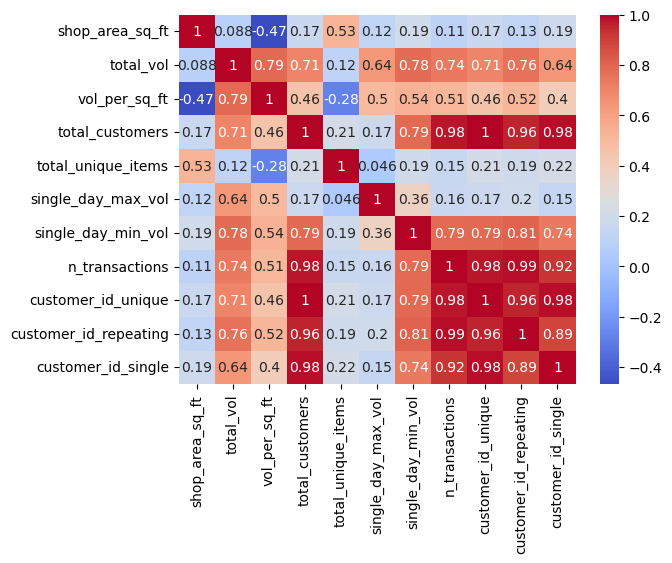

In [17]:
# create a correlation matrix
corr_matrix = storedata.corr()

# create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

In [18]:
storedata.columns

Index(['shop_id', 'shop_area_sq_ft', 'shop_profile', 'total_vol',
       'vol_per_sq_ft', 'total_customers', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single'],
      dtype='object')

## Selected Features


In [19]:
all = ['shop_area_sq_ft', 'total_vol',
       'vol_per_sq_ft', 'total_customers', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single']

keep_all =  []

Two_best_MI = ['shop_area_sq_ft', 'total_vol',
       'vol_per_sq_ft', 'total_customers', 'total_unique_items',
       'single_day_max_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating']

Two_best_MI_and_area = ['total_vol',
       'vol_per_sq_ft', 'total_customers', 'total_unique_items',
       'single_day_max_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating']

First_sub = ['vol_per_sq_ft', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single']

First_sub_without_area = ['shop_area_sq_ft','vol_per_sq_ft', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single']

Combine_best_two_subs = ['vol_per_sq_ft', 'total_unique_items',
       'single_day_max_vol', 'n_transactions','total_customers',
       'customer_id_unique', 'customer_id_repeating']

Area_and_vol = ['vol_per_sq_ft', 'total_vol', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single']

storedata = storedata.drop(Area_and_vol,axis = 1)

<AxesSubplot:>

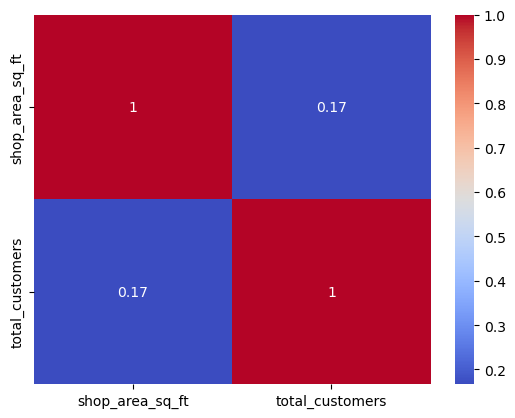

In [20]:
# create a correlation matrix
corr_matrix = storedata.corr()

# create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

## Train test split (basically removing the testing data specified)

In [21]:
# Create a boolean mask for filtering shopdata
mask = storedata['shop_id'].isin(testdata['shop_id'])

# Create two separate dataframes
test_shops = storedata[mask]
train_shops = storedata[~mask]

In [22]:
test_shops = test_shops.drop('shop_profile', axis=1)
test_shops

,shop_id,shop_area_sq_ft,total_customers
100,SHOP046,545,1736
101,SHOP024,676,1641
102,SHOP023,617,2227
103,SHOP097,310,1669
104,SHOP044,715,1552
105,SHOP030,530,1637
106,SHOP038,411,1781
107,SHOP029,597,2052
108,SHOP096,676,2497
109,SHOP092,617,2247


In [23]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_customers
0,SHOP047,528,Moderate,928
1,SHOP009,676,High,2498
2,SHOP083,676,Low,1900
3,SHOP117,676,Low,2037
4,SHOP042,676,Low,1841
...,...,...,...,...
95,SHOP124,606,High,2281
96,SHOP012,336,Low,1263
97,SHOP093,705,High,1493
98,SHOP004,516,Low,1744


## Encoding the target variable 

### Ordinal encoding
0 = Low
1 = Moderate
2 = High

In [24]:
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

# Define the mapping of labels to integer codes
label_mapping = {
    'Low': 0,
    'Moderate': 1,
    'High': 2
}

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the shop_profile column in train_shops
train_shops['shop_profile'] = encoder.fit_transform(train_shops['shop_profile'].map(label_mapping))


In [25]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_customers
0,SHOP047,528,1,928
1,SHOP009,676,2,2498
2,SHOP083,676,0,1900
3,SHOP117,676,0,2037
4,SHOP042,676,0,1841
...,...,...,...,...
95,SHOP124,606,2,2281
96,SHOP012,336,0,1263
97,SHOP093,705,2,1493
98,SHOP004,516,0,1744


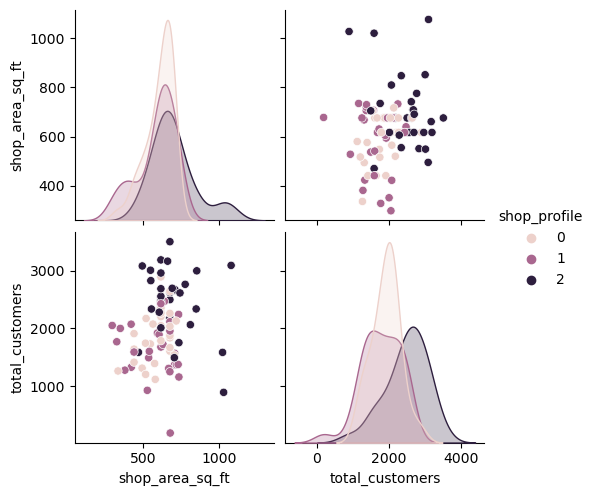

In [26]:
sns.pairplot(train_shops, hue='shop_profile')

## Spliting for crossvalidation

In [27]:
y = train_shops['shop_profile']
X = train_shops.drop('shop_profile', axis=1)
X = X.drop('shop_id',axis = 1)

In [28]:
y

0     1
1     2
2     0
3     0
4     0
     ..
95    2
96    0
97    2
98    0
99    2
Name: shop_profile, Length: 100, dtype: int64

In [29]:
X

,shop_area_sq_ft,total_customers
0,528,928
1,676,2498
2,676,1900
3,676,2037
4,676,1841
...,...,...
95,606,2281
96,336,1263
97,705,1493
98,516,1744


## MI Scores

In [30]:
from sklearn.feature_selection import mutual_info_classif

# X is a matrix of features, y is a vector of target variable
mi_scores = mutual_info_classif(X, y)

# Get the names of the features
feature_names = list(X.columns)

# Print the MI scores with the feature names
for i, score in enumerate(mi_scores):
    print(f"{feature_names[i]}: {score:.2f}")


shop_area_sq_ft: 0.06
total_customers: 0.17


### Train test split

In [31]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

## Training the model

In [32]:
train_X

,shop_area_sq_ft,total_customers
48,720,1370
6,617,2496
99,691,2695
82,605,1894
76,617,2959
...,...,...
96,336,1263
67,520,2172
64,617,2474
47,617,1678


In [33]:
train_y

48    1
6     1
99    2
82    1
76    2
     ..
96    0
67    0
64    2
47    1
44    1
Name: shop_profile, Length: 75, dtype: int64

In [34]:
val_X

,shop_area_sq_ft,total_customers
26,594,1920
86,441,1591
2,676,1900
55,661,3164
75,549,3007
93,555,2336
16,495,3081
73,541,1603
54,617,2362
95,606,2281


In [35]:
val_y

26    1
86    1
2     0
55    2
75    2
93    2
16    2
73    1
54    1
95    2
53    2
92    0
78    1
13    1
7     1
30    2
22    2
24    0
33    0
8     0
43    1
62    2
3     0
71    1
45    0
Name: shop_profile, dtype: int64

### Training model

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Define the model with default hyperparameters
model = XGBClassifier()
# model = KNeighborsClassifier(n_neighbors= 25)
# model = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

## Making predictions

In [38]:
# Make predictions on the test data
y_pred = model.predict(val_X)

## F1 Score

In [39]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(val_y, y_pred,average='micro')

# Print the result
print("F1 score:", f1)

F1 score: 0.56


## For submissions Train using full X and y sets

In [40]:
# Define the model with default hyperparameters
FinalModel = XGBClassifier()
# FinalModel = KNeighborsClassifier(n_neighbors=3)
# FinalModel = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
FinalModel.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [41]:
test_shops = test_shops.drop('shop_id', axis=1)
test_shops

,shop_area_sq_ft,total_customers
100,545,1736
101,676,1641
102,617,2227
103,310,1669
104,715,1552
105,530,1637
106,411,1781
107,597,2052
108,676,2497
109,617,2247


In [42]:
FinalPred = FinalModel.predict(test_shops)

In [43]:
len(FinalPred)

24

## Combining predictions with shop_id

In [44]:
# Create a dictionary mapping the old values to the new values
mapping = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Map the values in the 'shop_profile' column using the dictionary
testdata["shop_profile"] = FinalPred

In [45]:
testdata

,shop_id,shop_profile
0,SHOP046,0
1,SHOP024,0
2,SHOP023,0
3,SHOP097,1
4,SHOP044,1
5,SHOP030,0
6,SHOP038,0
7,SHOP029,1
8,SHOP096,2
9,SHOP092,0


In [46]:
# Define a dictionary to map values to labels
label_map = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Replace the values in the shop_profile column with labels
testdata['shop_profile'] = testdata['shop_profile'].replace(label_map)

In [47]:
## Write to CSV
testdata.to_csv('output.csv', index=False)
print("Done!!")

Done!!
